# Data Preprocessing

This notebook contains data preprocessing steps for all columns of the imported data alongside exploratory data analysis. It focuses on the columns **postcode** and **original_product_names**.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# helpful character encoding module
import chardet

# regex package
import re

# for reversing character encoding issues 
import ftfy

# 'fuzz' to compare TWO strings, 'process' to compare a string to MULTIPLE other strings
from fuzzywuzzy import fuzz, process

In [2]:
# display setting for rows
pd.set_option('display.max_rows', 100) 

## 1. Load raw data

In [3]:
file_path = '../data/raw/interview_signup.csv'

In [4]:
# check first couple thousand bytes to guess character encoding of csv
with open(file_path, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(20000))

print(result)

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


In [5]:
# load csv with raw data
encoding = 'utf-8'
sep = ',' 
type_dict = {'original_product_name': str,
             'postcode': str,
             'bundesland': str,
             'total_bonus': 'float64',
             'order_date': str}

df_raw = pd.read_csv(file_path, 
                     encoding=encoding, 
                     sep=sep,
                     header=0,
                     dtype=type_dict
)

# make a copy to leave variable df_raw untouched
df = df_raw.copy()  
df.tail(5)

,original_product_name,postcode,bundesland,total_bonus,order_date
318340,E.ON STROM 24,49610,Niedersachsen,147.0,2018-12-31
318341,E.ON STROM,4916.0,NaN,142.0,2018-12-31
318342,E.ON STROM,77972.0,Baden-Württemberg,48.0,2018-12-31
318343,E.ON STROM ÖKO 24,91466,Bayern,238.0,2018-12-31
318344,E.ON STROM PUR,88145,Bayern,125.0,2018-12-31


## 2. Check data quality

### 2.1 General

In [6]:
# data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318345 entries, 0 to 318344
Data columns (total 5 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   original_product_name  318345 non-null  object 
 1   postcode               318345 non-null  object 
 2   bundesland             288813 non-null  object 
 3   total_bonus            318345 non-null  float64
 4   order_date             318345 non-null  object 
dtypes: float64(1), object(4)
memory usage: 12.1+ MB


Check if there are any duplicate rows in the dataset.

In [7]:
# check number of duplicate rows
print('Number of duplicate rows: ', df.duplicated().sum())


Number of duplicate rows:  170


In [8]:
# before dropping, check duplicates where bundesland is empty
# df.loc[df.duplicated(keep=False) & df['bundesland'].isna()]

In [9]:
# delete duplicates
df = df.drop_duplicates()

Before cleansing of the columns, get an idea about percentage of missing records per columns

In [10]:
# missing values 
print('\nMissing values (%):')
print(np.round(df.isna().sum() / df.shape[0] * 100, 2))



Missing values (%):
original_product_name    0.00
postcode                 0.00
bundesland               9.28
total_bonus              0.00
order_date               0.00
dtype: float64


In [11]:
# check if we really need float64 to store the total_bonus or if we can save some memory by using int.

# if total_bonus converted to int are identical with float, use int
#if sum(df['total_bonus'] != df['total_bonus'].astype(int)) == 0:
#    df['total_bonus'] = df['total_bonus'].astype(int)

### 2.1 postcode

We have no missing values for postcode in the dataset. Because we specified dtype in read_csv(), we do not get mixed datatypes here:

In [11]:
# check for mixed datatypes 
df.postcode.apply(type).value_counts()

postcode
<class 'str'>    318175
Name: count, dtype: int64

In [12]:
# check if there might still be some characters inside by converting to int
# df['postcode'] = df['postcode'].astype(int)

To check the validity of postcode entries, use a regex to check against the records.

In [13]:
# Define custom function that validates postcodes 
def validate_postcode(postal_code):
    '''
        Checks if the specified postcode is valid by matching it with a simplified regex for German postal codes.
    
        Parameters:
            postal_code (str): The postcode to be checked for validity.
    
        Returns:
            bool: True if the input is valid, False otherwise.   
    '''
    valid_postcode = r"^[0-9]{5}$"
    if re.match(valid_postcode, postal_code):
        return True
    else:
        return False

Use the custom function above to identify valid postcode formats in the dataframe column:

In [14]:
# get logical index of valid postcodes
idx_valid_postcode = df.postcode.apply(validate_postcode)

# display some invalid postcodes
print("Number of remaining invalid postcodes: ", sum(~idx_valid_postcode))
df.loc[~idx_valid_postcode, 'postcode'].sample(10)

Number of remaining invalid postcodes:  91310


233302    60433.0
297351     2797.0
202653    65623.0
299324    48165.0
275928    69115.0
227540       8267
79829     23683.0
222388    63526.0
121018    39576.0
71792     70794.0
Name: postcode, dtype: object

We can observe 2 causes for invalid postcodes: 
    
(i) trailing ".0", or 

(ii) 4 digits only.

When addressing (i), we need to ensure that the pattern ".0" is only removed from records at meaningful places. We use string split for this:

In [15]:
def remove_trailing_decimal_pattern(string):
    """
    This function splits a string at the pattern ".0" and only returns the left side.
    
    Parameters:
        string (str): string to checked against pattern.
    
    Returns
        string: All characters of the string before the first ".0" pattern occurs.
    """
    return string.split(".0")[0]

In [16]:
df['postcode'] = df['postcode'].apply(remove_trailing_decimal_pattern)

# alt.:
# df['postcode'] = df['postcode'].apply(lambda x: x.split(".0")[0])

In [17]:
# examine the invalid postcode cases that are still left
idx_valid_postcode = df.postcode.apply(validate_postcode)
print("Number of remaining invalid postcodes: ", sum(~idx_valid_postcode))
print("\nSample of invalid postcodes: \n", df.loc[~idx_valid_postcode, 'postcode'].sample(10))

Number of remaining invalid postcodes:  16610

Sample of invalid postcodes: 
 175063    6567
265114    6237
155608    6317
11471     3226
205949    4442
92035     4849
236817    1833
64286     9619
38813     6682
25079     6120
Name: postcode, dtype: object


We improved from 91,310 invalid records to 16,610 in this step. That's an improvement of roughly 80%. 

Before we tackle (ii), however, we make sure *not* to add "0" digits to other invalid postcodes in the dataset that have more - or less - than 4 digit postcodes. Therefore, let's check the distribution of digits of the remaining 16,616 invalid postcodes:

In [18]:
# number of digits of remaining invalid postcodes
df.loc[~idx_valid_postcode, 'postcode'].apply(len).value_counts()

postcode
4     16609
10        1
Name: count, dtype: int64

Seems like we have 1 odd record with a 10 digits postcode. Let's look into this record closer:

In [19]:
df.loc[df['postcode'].apply(len)==10, :]

,original_product_name,postcode,bundesland,total_bonus,order_date
266922,E.ON STROM,92696JAVAS,NaN,97.0,2018-11-03


Unfortunately, there is no state in the row with index 266922. If the state was "Bayern" (see cell below), we could have been quite confident in recovering the postcode by taking the first 5 characters of the string "92696JAVAS". Since it is only 1 record, drop this row.

In [20]:
# find records with leading 5 digits of 92696JAVAS
df.loc[df['postcode']=='92696']

,original_product_name,postcode,bundesland,total_bonus,order_date
13583,E.ON STROM 24,92696,Bayern,129.0,2018-01-16
56134,E.ON STROM,92696,Bayern,184.0,2018-03-06
56439,E.ON STROM 24,92696,Bayern,140.0,2018-03-06
57739,E.ON STROM,92696,Bayern,77.0,2018-03-08
73239,E.ON STROM 24,92696,Bayern,221.0,2018-03-26
124958,E.ON STROM,92696,Bayern,152.0,2018-05-24
154379,E.ON STROM ÖKO 24,92696,Bayern,143.0,2018-06-27
166329,E.ON STROM,92696,NaN,264.0,2018-07-10
173790,E.ON STROM,92696,Bayern,153.0,2018-07-19
205955,E.ON STROM 24,92696,Bayern,116.0,2018-08-25


In [21]:
# drop row with index 266922
df = df.drop(index=266922)

Now, we can be very certain that we only need to deal with 4 digit postcodes from here on:

The **naiv approach** would be to simply add a leading "0" to all remaining 4 digit records, since most likely it was removed during type conversion to int or float. If we had access to processing pipeline of the data source, this could be verified rather easily. Since we can't be 100% sure whether all of the remaining records are missing a leading 0 or are corrupted otherwise, we take a more **conservative approach**:

To further clean the invalid entries of this column, we can use the fact that only the federal states "Sachsen", "Brandenburg", "Sachsen-Anhalt" and "Thüringen" have a leading "0" in their postal code. For rows still having invalid postcodes **and** one of these states, we can add a "0" to the postcodes.

In [22]:
# check the unique states for the remaining invalid postcodes
df.loc[~idx_valid_postcode, 'bundesland'].value_counts(dropna=False)

bundesland
Sachsen           8637
NaN               3225
Sachsen-Anhalt    2137
Thüringen         1955
Brandenburg        655
Name: count, dtype: int64

For rows with non-empty 'bundesland', we can add a leading 0 and keep the data. For the records with no corresponding state, we need one final logical transformation step.

In [23]:
# logical index for all states with leading 0 as postcode
states_w_lead_0 = ["Sachsen", "Brandenburg", "Sachsen-Anhalt", "Thüringen"]
idx_state_w_lead_0 = df['bundesland'].isin(states_w_lead_0)

Next, let's pad all postcodes with "0" from the left until they reach 5 digits.

In [24]:
# pad all postcodes with "0" from the right until they have 5 digits
df.loc[idx_state_w_lead_0, 'postcode'] = df.loc[idx_state_w_lead_0, 'postcode'].str.rjust(5, fillchar='0')

In [25]:
# confirm successful transformation
# df.loc[idx_state_w_lead_0, ['postcode','bundesland']].sample(15)

In [26]:
# examine the invalid postcode cases that are still left
idx_valid_postcode = df.postcode.apply(validate_postcode)

# display invalid postcodes: 4 digits
print("Number of remaining invalid postcodes: ", sum(~idx_valid_postcode))
print("\nSample of remaining invalid postcodes: \n", df.loc[~idx_valid_postcode, ['postcode', 'bundesland']].sample(10))

Number of remaining invalid postcodes:  3225

Sample of remaining invalid postcodes: 
        postcode bundesland
161989     7318        NaN
11394      4916        NaN
217469     3226        NaN
160079     3058        NaN
141214     6242        NaN
289922     6618        NaN
118750     8223        NaN
101927     3048        NaN
40390      9429        NaN
127063     9619        NaN


Lastly, we deal with the remaining 3,225 records with invalid postcode where the 'bundesland' column is empty. Compared to the initial 91,310 invalid cases, we have recovered over 96% of the corrupted records already. 

Taking the **conservative approach** (because we seem to have enough data), we can still make use of the N:1 relationship between postcodes and states (i.e., one postcode can only have one state). The idea is to infer the remaining unclear cases by assuming a leading 0 and see if this resulting postcode can be found elsewhere in the dataset with an assigned state in ["Sachsen", "Brandenburg", "Sachsen-Anhalt", "Thüringen"].

In [27]:
# init a dictionary for storage of data
dict_pc = {} 

# logical index for all rows of the dataframe without a state entry
idx_state_not_empty = ~df['bundesland'].isna()

# loop through remaining postcodes
for pc in list(df.loc[~idx_valid_postcode, 'postcode'].unique()):
    
    # create a dummy postcode with leading "0"
    dummy_pc = "0" + pc
    
    # logical index for positions of current postcode iterator
    idx_dummy_match = df['postcode']==dummy_pc
    
    # check if there are other records with same postcode and filled out state
    if any(idx_dummy_match):
        if all(df.loc[idx_dummy_match & idx_state_not_empty, 'bundesland'].isna()):
            pass
        elif len(set(df.loc[idx_dummy_match & idx_state_not_empty, 'bundesland'])) > 1:  # if one postcode has several states
            pass
        elif not set(df.loc[idx_dummy_match & idx_state_not_empty, 'bundesland']).issubset(states_w_lead_0):  # if the postcodes correspond to any of the 4 states above
            pass
        else:            
            dict_pc[pc] = set(df.loc[idx_dummy_match & idx_state_not_empty, 'bundesland'])
    
print(dict_pc)

{'9366': {'Sachsen'}, '4626': {'Thüringen'}, '1594': {'Sachsen'}, '4769': {'Sachsen'}, '1990': {'Brandenburg'}, '1737': {'Sachsen'}, '9573': {'Sachsen'}, '6217': {'Sachsen-Anhalt'}, '1968': {'Brandenburg'}, '8107': {'Sachsen'}, '4924': {'Brandenburg'}, '3096': {'Brandenburg'}, '7613': {'Thüringen'}, '7426': {'Thüringen'}, '8223': {'Sachsen'}, '2742': {'Sachsen'}, '7570': {'Thüringen'}, '8468': {'Sachsen'}, '6632': {'Sachsen-Anhalt'}, '7422': {'Thüringen'}, '2991': {'Sachsen'}, '6618': {'Sachsen-Anhalt'}, '8606': {'Sachsen'}, '1904': {'Sachsen'}, '2894': {'Sachsen'}, '7806': {'Thüringen'}, '1723': {'Sachsen'}, '4828': {'Sachsen'}, '3149': {'Brandenburg'}, '6642': {'Sachsen-Anhalt'}, '1920': {'Sachsen'}, '8626': {'Sachsen'}, '2906': {'Sachsen'}, '1855': {'Sachsen'}, '2747': {'Sachsen'}, '4916': {'Brandenburg'}, '4827': {'Sachsen'}, '8541': {'Sachsen'}, '1609': {'Sachsen'}, '6628': {'Sachsen-Anhalt'}, '6268': {'Sachsen-Anhalt'}, '8233': {'Sachsen'}, '6242': {'Sachsen-Anhalt'}, '8527': {'S

In [28]:
df.loc[df['postcode'].isin(dict_pc.keys()), 'postcode'] = df.loc[df['postcode'].isin(dict_pc.keys()), 'postcode'].str.rjust(5, fillchar='0')

In [29]:
# examine the invalid postcode cases that are still left
idx_valid_postcode = df.postcode.apply(validate_postcode)

# display invalid postcodes: 4 digits
print("Number of remaining invalid postcodes: ", sum(~idx_valid_postcode))
print("\nSample of remaining invalid postcodes: \n", df.loc[~idx_valid_postcode, ['postcode', 'bundesland']].sample(10))

Number of remaining invalid postcodes:  2351

Sample of remaining invalid postcodes: 
        postcode bundesland
94034      9669        NaN
269272     6385        NaN
303896     2977        NaN
37374      3044        NaN
117725     3044        NaN
276039     6567        NaN
187273     3053        NaN
47804      3044        NaN
43279      9376        NaN
9484       2689        NaN


We have 2,351 invalid postcodes left from originally 91,310 (97,5% recovery rate). If data would not be vastly available, we might add a leading 0 to the rest of the records. For now, let's avoid false-positive or false-negative classification as much as we can where overall information quality is not great. 

Therefore, we drop the rest of the rows. But before, let's check if the remaining invalid records can be systematically linked to anomalies in other columns (e.g. all happened around the same time of the year):

In [30]:
# get sample of remaining invalid postcodes
df.loc[~idx_valid_postcode, :].sample(5)

,original_product_name,postcode,bundesland,total_bonus,order_date
290063,E.ON STROM ÖKO 24,2692,NaN,119.0,2018-11-29
180177,E.ON STROM ÖKO,3050,NaN,203.0,2018-07-26
307282,E.ON STROM,6114,NaN,164.0,2018-12-19
146347,E.ON STROM,6366,NaN,146.0,2018-06-18
204614,E.ON STROM,9350,NaN,146.0,2018-08-24


In [31]:
# Can the missing postcodes be systematically attributed to a date?

# number of invalid postcodes by order_date
df.loc[~idx_valid_postcode, :].groupby(by=['order_date'])['postcode'].count().describe()  # .sort_values(ascending=False)
# df.loc[~idx_valid_postcode, 'order_date'].value_counts().sort_values(ascending=False)
# df.loc[~idx_valid_postcode, :].groupby(by=['order_date'])['postcode'].count().plot()

# number of valid postcodes with empty state by order_date
df.loc[~idx_state_not_empty & idx_valid_postcode, :].groupby(by=['order_date'])['postcode'].count().describe()  # sort_values(ascending=False)
# df.loc[~idx_state_not_empty & idx_valid_postcode, :].groupby(by=['order_date'])['postcode'].count().plot()


count    365.000000
mean      74.435616
std        8.519167
min       48.000000
25%       68.000000
50%       75.000000
75%       80.000000
max       99.000000
Name: postcode, dtype: float64

In [32]:
# drop rows with invalid postcodes
df.drop(df.loc[~idx_valid_postcode].index, inplace=True)

Finally, we check again for duplicated records, since the cleaning of postcodes may have created new duplicates that we missed before.

In [33]:
# check number of duplicate rows
print('Number of duplicate rows: ', df.duplicated().sum())

Number of duplicate rows:  62


In [34]:
# drop duplicates
df = df.drop_duplicates()

In [35]:
df.shape[0]

315761

### 2.2 bundesland

In [ ]:
# convert int to category for memory
df['original_product_name'] = df['original_product_name'].astype("category")

In [36]:
# missing values
df['bundesland'].isna().sum()

27162

In [37]:
len(df['bundesland'].unique())

17

In [38]:
df['bundesland'].value_counts(dropna=False)

bundesland
Nordrhein-Westfalen       68454
Bayern                    50718
Baden-Württemberg         35430
Niedersachsen             34850
NaN                       27162
Hessen                    19886
Rheinland-Pfalz           16342
Schleswig-Holstein        12956
Brandenburg                8791
Sachsen                    8637
Berlin                     8255
Thüringen                  5972
Mecklenburg-Vorpommern     5478
Sachsen-Anhalt             4453
Hamburg                    3951
Saarland                   2986
Bremen                     1440
Name: count, dtype: int64

Check if there exists a N:1 relationship between postcode and bundesland:

In [39]:
# check if the N:1 relationship between postcode and state is obeyed
# BEWARE: there are very few special cases where one postcode can belong to more than one state
no_violations = sum(df.groupby(by=['postcode'])['bundesland'].nunique()>1)
print('Number of N:1 relationship violations between postcode and bundesland: ', no_violations)

Number of N:1 relationship violations between postcode and bundesland:  9


In [40]:
# retrieve the postcodes
violations = df.groupby(by=['postcode'])['bundesland'].nunique()>1
pc_violations = list(violations.index[violations])
print(pc_violations)

['14715', '17337', '19357', '21039', '22113', '22145', '59969', '65391', '69434']


In [42]:
# create dataframe with the counts of each postcode, bundesland combination
grouping = df.loc[df['postcode'].isin(pc_violations),:].groupby(by=['postcode','bundesland'])['order_date'].count()  
df_grouping = grouping.to_frame()

# Convert tuple index back to two separate columns
df_grouping = df_grouping.reset_index()
df_grouping.columns = ['postcode', 'bundesland', 'count']

print(df_grouping)

   postcode              bundesland  count
0     14715             Brandenburg     70
1     14715          Sachsen-Anhalt      6
2     17337             Brandenburg     11
3     17337  Mecklenburg-Vorpommern      8
4     19357             Brandenburg      7
5     19357  Mecklenburg-Vorpommern      2
6     21039                 Hamburg     20
7     21039      Schleswig-Holstein     59
8     22113                 Hamburg      3
9     22113      Schleswig-Holstein     24
10    22145                 Hamburg     33
11    22145      Schleswig-Holstein     27
12    59969                  Hessen     16
13    59969     Nordrhein-Westfalen     24
14    65391                  Hessen     23
15    65391         Rheinland-Pfalz      1
16    69434       Baden-Württemberg      1
17    69434                  Hessen      9


Upon manual checks, all the above cases are valid. The data is not corrupted. 
To fill the missing bundesland values, we use the mapping between postcode and bundesland. For each missing bundesland entries, we use their postcodes to infer the state from other existing records where the state was filled. 
For any given cases, we fill NaNs with that most occuring state (and set the occurance of NaN entries to 0 by design)

In [41]:
# create a dictionary with all unique postcode. 
# Count the number of occurance for all unique states assigned to this postcode and store it in a list of tuples 

# init final dict
dict_pc = {}

# loop through all unique postcodes
for pc in list(df['postcode'].unique()):
    
    # logical index for current postcode
    idx_pc = df['postcode']==pc
    
    # list of unique states for current postcode (with NaN)
    list_state = list(df.loc[idx_pc, 'bundesland'].unique())
    
    # init list 
    dict_pc[pc] = []
    
    # loop through all unique states of current postcode
    for state in list_state:
        
        # count occurences of states for current postcode 
        dict_pc[pc].append((state, sum(idx_pc & (df['bundesland']==state))))  # NaN will be counted as 0 occurance
    

In [42]:
postcode_state_mapping = {}

for key, tuples in dict_pc.items():
    max_occur_state_tuple = max(tuples, key=lambda x: x[1])
    postcode_state_mapping[key] = max_occur_state_tuple[0]  # get state with most occurances

print(postcode_state_mapping)

{'53229': 'Nordrhein-Westfalen', '74235': 'Baden-Württemberg', '45257': 'Nordrhein-Westfalen', '64395': 'Hessen', '36039': 'Hessen', '12357': 'Berlin', '13088': 'Berlin', '73207': 'Baden-Württemberg', '23795': 'Schleswig-Holstein', '58638': 'Nordrhein-Westfalen', '37079': 'Niedersachsen', '88605': 'Baden-Württemberg', '26810': 'Niedersachsen', '30890': 'Niedersachsen', '39326': 'Sachsen-Anhalt', '85646': 'Bayern', '58454': 'Nordrhein-Westfalen', '31749': 'Niedersachsen', '30880': 'Niedersachsen', '31162': 'Niedersachsen', '88512': 'Baden-Württemberg', '52152': 'Nordrhein-Westfalen', '70567': 'Baden-Württemberg', '57520': 'Rheinland-Pfalz', '04319': 'Sachsen', '46045': 'Nordrhein-Westfalen', '90762': 'Bayern', '45964': 'Nordrhein-Westfalen', '77948': 'Baden-Württemberg', '28199': 'Bremen', '30171': 'Niedersachsen', '08315': 'Sachsen', '21266': 'Niedersachsen', '10627': 'Berlin', '16341': 'Brandenburg', '28201': 'Bremen', '69198': 'Baden-Württemberg', '60596': nan, '99988': nan, '64572':

In [43]:
for key, val in postcode_state_mapping.items():
    
    # logical index on current postcode
    idx_pc = df['postcode']==key
    
    # logical index on missing values
    idx_state_empty = df['bundesland'].isna()
        
    # fillna
    df.loc[idx_pc & idx_state_empty, 'bundesland'] = val

In [44]:
df['bundesland'].isna().sum()

20028

This method reduced the number of missing values from 27,162 to 20,028 (26% recovery). For the remaining empty entries, we could either use a external dataset (or api) with postcode - state mappings or try geocoding.

### 2.3 order_date

In [11]:
# what different data types are in the column order_date?
df.order_date.apply(type).value_counts()

order_date
<class 'str'>    318175
Name: count, dtype: int64

In [19]:
# convert order_date to date
df['order_date'] = pd.to_datetime(df['order_date'], format="%Y-%m-%d")
df['order_date'] = df['order_date'].dt.date

In [21]:
#pd.to_datetime(df['order_date'], errors='coerce', format="%Y-%m-%d").isnull().sum()

0

In [37]:
# check for missing dates
day_diffs = [el.days for el in np.diff(df['order_date'].unique())]
print("Number of unique dates: ", len(day_diffs))
print("Number of consecutive days: ", day_diffs.count(1))

Number of unique dates:  364
Number of consecutive days:  364


In [38]:
# number of rows per date
df['order_date'].value_counts().describe()
# df['order_date'].value_counts().plot.bar()

count    365.000000
mean     872.175342
std       29.689176
min      797.000000
25%      853.000000
50%      872.000000
75%      892.000000
max      960.000000
Name: count, dtype: float64

### 2.4 total_bonus

How are the data distributed?

In [12]:
df['total_bonus'].describe()

count    318175.000000
mean        150.592620
std          53.698531
min           0.000000
25%         112.000000
50%         149.000000
75%         182.000000
max         570.000000
Name: total_bonus, dtype: float64

In [16]:
df.loc[(df['total_bonus']>0) & (df['total_bonus']<20)]

,original_product_name,postcode,bundesland,total_bonus,order_date
215,E.ON STROM ÖKO,41238,Nordrhein-Westfalen,17.0,2018-01-01
641,E.ON STROM,21493.0,Schleswig-Holstein,18.0,2018-01-01
890,E.ON STROM,22043,Hamburg,9.0,2018-01-02
1203,E.ON STROM 24,7958.0,Thüringen,12.0,2018-01-02
3033,E.ON STROM 24,54329,Rheinland-Pfalz,8.0,2018-01-04
...,...,...,...,...,...
316702,E.ON STROM,41812,Nordrhein-Westfalen,13.0,2018-12-30
316738,E.ON STROM 24,7907.0,Thüringen,11.0,2018-12-30
316914,E.ON STROM,76891,NaN,18.0,2018-12-30
317136,E.ON STROM,18374,Mecklenburg-Vorpommern,17.0,2018-12-30


In [18]:
df.loc[df['total_bonus']>=400]

,original_product_name,postcode,bundesland,total_bonus,order_date
572,E.ON STROM,91257,Bayern,436.0,2018-01-01
4254,E.ON STROM ÖKO,53343.0,Nordrhein-Westfalen,461.0,2018-01-05
4640,E.ON STROM ÖKO 24,24629,Schleswig-Holstein,428.0,2018-01-06
6259,E.ON STROM ÖKO,14050,Berlin,428.0,2018-01-08
7362,E.ON STROM ÖKO 24,35647,Hessen,430.0,2018-01-09
...,...,...,...,...,...
308905,E.ON STROM,12353,Berlin,418.0,2018-12-21
310518,E.ON STROM,31246,Niedersachsen,414.0,2018-12-23
313070,E.ON STROM ÖKO 24,24939,Schleswig-Holstein,420.0,2018-12-26
315651,E.ON STROM,90491,Bayern,421.0,2018-12-28


<Axes: >

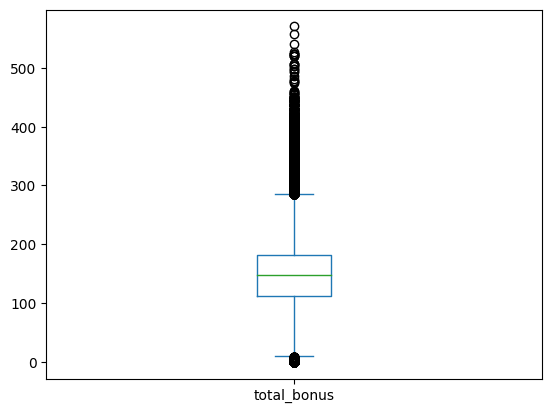

In [74]:
# boxplot 
df['total_bonus'].plot(kind='box')

<Axes: xlabel='total_bonus', ylabel='Count'>

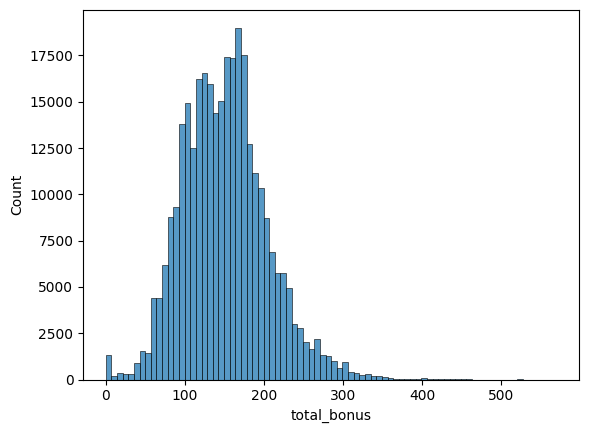

In [69]:
# empirical distribution
sns.histplot(df['total_bonus'], bins=80)

In [ ]:
# test for normality? scipy -> statisitcal tests, qqplot, ...

Are values of ```total_bonus=0``` correct? Check if there are anomalies in other features that may cause total_bonus to be 0:

In [70]:
# create df where all total_bonus are 0
df_no_bonus = df.loc[df['total_bonus']==0, :]

# fill missing states with 'leer' so that it appears in countplots
df['bundesland'] = df['bundesland'].fillna('leer')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, 'Rheinland-Pfalz'),
  Text(1, 0, 'Niedersachsen'),
  Text(2, 0, 'Bayern'),
  Text(3, 0, 'Nordrhein-Westfalen'),
  Text(4, 0, 'Schleswig-Holstein'),
  Text(5, 0, 'Brandenburg'),
  Text(6, 0, 'Hessen'),
  Text(7, 0, 'Baden-Württemberg'),
  Text(8, 0, 'leer'),
  Text(9, 0, 'Mecklenburg-Vorpommern'),
  Text(10, 0, 'Berlin'),
  Text(11, 0, 'Thüringen'),
  Text(12, 0, 'Hamburg'),
  Text(13, 0, 'Sachsen-Anhalt'),
  Text(14, 0, 'Saarland'),
  Text(15, 0, 'Sachsen')])

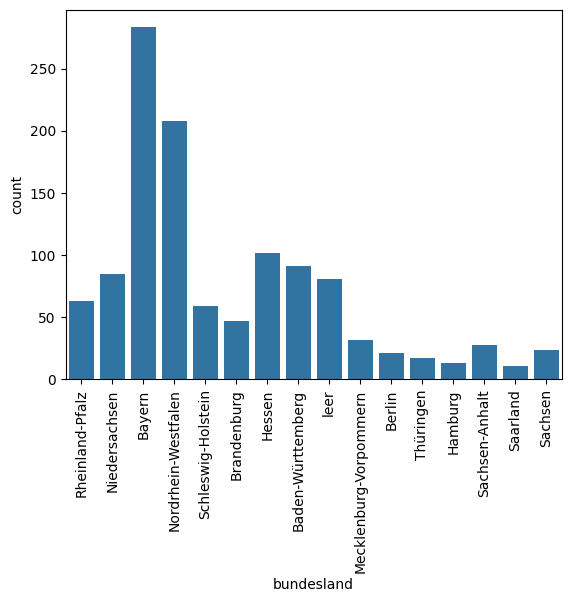

In [71]:
sns.countplot(data=df_no_bonus, x='bundesland')
plt.xticks(rotation=90)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'E.ON STROM ÖKO 24'),
  Text(1, 0, 'E.ON STROM PUR'),
  Text(2, 0, 'E.ON STROM 24'),
  Text(3, 0, 'E.ON STROM ÖKO'),
  Text(4, 0, 'E.ON STROM')])

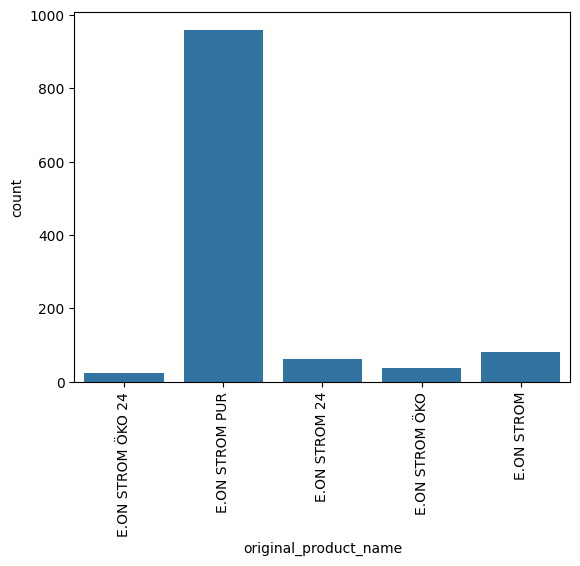

In [72]:
sns.countplot(data=df_no_bonus, x='original_product_name')
plt.xticks(rotation=90)

In [ ]:
# test cou

<Axes: xlabel='doy'>

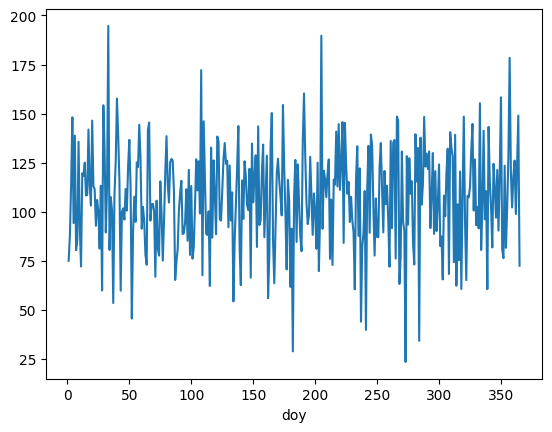

In [99]:
df.loc[df['original_product_name']=='E.ON STROM PUR',:].groupby(by = ['doy'])['total_bonus'].mean().plot()

Most of the cases where ```total_bonus = 0``` coincides with customers choosing the E.ON STROM PUR product.

Can we observe temporal patterns, where total_bonus is zero?

In [97]:
# day of year
df['doy'] = pd.to_datetime(df['order_date']).dt.day_of_year

df_group_doy = df.groupby('doy')['total_bonus'].mean().to_frame()
df_group_doy = df_group_doy.reset_index()

<Axes: xlabel='doy', ylabel='total_bonus'>

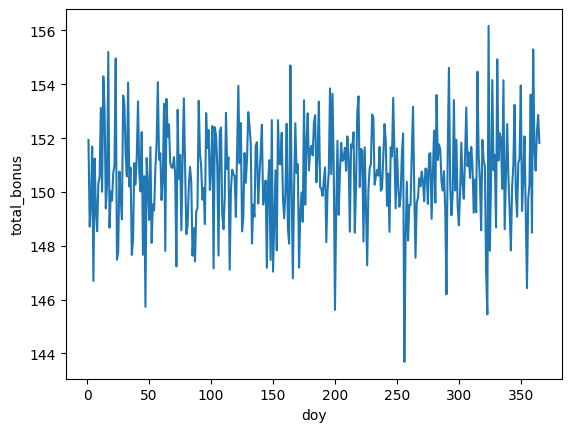

In [94]:
sns.lineplot(data = df_group_doy, x='doy', y='total_bonus')

Are there aggregated monthly or weekly anomalies?

<Axes: xlabel='week'>

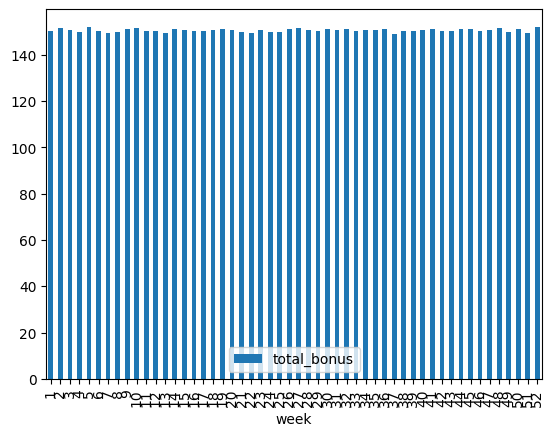

In [41]:
df['week'] = pd.to_datetime(df['order_date']).dt.isocalendar().week
df[['week','total_bonus']].groupby(by=['week']).mean().plot.bar()

In [42]:
df['month-year'] = pd.to_datetime(df['order_date']).dt.strftime('%B-%Y')
print(df[['month-year','total_bonus']].groupby(by=['month-year']).mean())

# df[['month-year','total_bonus']].groupby(by=['month-year']).mean().plot.bar()

                total_bonus
month-year                 
April-2018       150.554124
August-2018      150.842170
December-2018    150.801237
February-2018    150.364844
January-2018     150.679405
July-2018        150.773554
June-2018        150.469014
March-2018       150.410206
May-2018         150.467409
November-2018    150.948660
October-2018     150.611958
September-2018   150.130018


### 2.5 original_product_name

Understand unique values: 

In [12]:
print('Number of unique values: ', df['original_product_name'].nunique())

df['original_product_name'].unique()

Number of unique values:  10


array(['E.ON STROM', 'E.ON STROM ÖKO', 'E.ON STROM ÖKO 24',
       'E.ON STROM 24', 'E.ON STROM PUR', 'E.ON STROM Ã–KO',
       'E.ON STROM 24 24 24', 'E.ON STROM 24 24', 'E.ON STROM ÖO',
       'E.ON STROM 24 24 24 24 24 24 24'], dtype=object)

In [13]:
# look at distribution of unique values
df['original_product_name'].value_counts()

original_product_name
E.ON STROM                         164339
E.ON STROM 24                       69344
E.ON STROM ÖKO                      55187
E.ON STROM ÖKO 24                   25431
E.ON STROM PUR                       3649
E.ON STROM Ã–KO                       206
E.ON STROM 24 24                       14
E.ON STROM 24 24 24                     2
E.ON STROM 24 24 24 24 24 24 24         2
E.ON STROM ÖO                           1
Name: count, dtype: int64

Type conversion to category to save memory

In [13]:
df['original_product_name'] = df['original_product_name'].astype("category")

Address misspellings with the following steps
1. some ambiguous data (i.e., E.ON STROM Ã–KO) seem to come from wrong encoding. We can use the ftfy library to retrieve desired characters
2. for the remaining inconsistencies, we apply a mapping that uses fuzzy matching to correct typos in the product name. We use fuzzy instead to more fancy techniques, because we care more about character-level similarities than about contextual similarity

In [27]:
# 1. Fix misspellings caused by encoding

# convert wrongly decoded characters to utf-8 
df['original_product_name'] = df['original_product_name'].apply(lambda x: ftfy.fix_text(x))

# check which products were converted 
converted_product_names = set(df_raw['original_product_name'].unique()).difference(set(df['original_product_name'].unique()))
print(f"These product names were successfully integrated into the existing products names: {converted_product_names}.\n")

# check if ftfy introduced new products 
new_product_names = set(df['original_product_name'].unique()).difference(set(df_raw['original_product_name'].unique()))
if len(new_product_names)==0:
    new_product_names=None
print(f"Potentially wrongly created new 'false positive' products names: {new_product_names}.")

These product names were successfully integrated into the existing products names: {'E.ON STROM Ã–KO'}.

Potentially wrongly created new 'false positive' products names: None.


We can see that the 206 instances of E.ON STROM Ã–KO now moved to E.ON STROM ÖKO (from 55,187 to 55,393)

In [28]:
df['original_product_name'].value_counts()

original_product_name
E.ON STROM                         164339
E.ON STROM 24                       69344
E.ON STROM ÖKO                      55393
E.ON STROM ÖKO 24                   25431
E.ON STROM PUR                       3649
E.ON STROM 24 24                       14
E.ON STROM 24 24 24                     2
E.ON STROM 24 24 24 24 24 24 24         2
E.ON STROM ÖO                           1
Name: count, dtype: int64

To make this cleaning process more scalable and less manual, we use fuzzywuzzy:
1. identify the real products manually
2. apply similarity measure 'token_sort_ratio' of fuzzywuzzy to quantify how close the odd product names are to the set of real ones -> Take the closest match with the real product name. Alternatively, define a similarity threshold that cannot be undercut. Otherwise, the character gets not matching and will be dropped later.
3. map this to the original column

In [29]:
# define actual product names
real_product_names = set(['E.ON STROM', 'E.ON STROM ÖKO', 'E.ON STROM ÖKO 24', 'E.ON STROM PUR', 'E.ON STROM 24'])

# get set of all unique entries (with misspellings)
all_product_names = set(df['original_product_name'].unique())

# identify all non-official product names
odd_product_names = all_product_names - real_product_names

In [30]:
# fuzzy matching
dict_fuzzy_matching = {}
for prod in odd_product_names:
    # extract only closest match with real product name
    dict_fuzzy_matching[prod] = process.extract(prod, real_product_names, limit=1, scorer=fuzz.token_sort_ratio)[0][0]
print(dict_fuzzy_matching)

{'E.ON STROM ÖO': 'E.ON STROM ÖKO', 'E.ON STROM 24 24 24 24 24 24 24': 'E.ON STROM 24', 'E.ON STROM 24 24 24': 'E.ON STROM 24', 'E.ON STROM 24 24': 'E.ON STROM 24'}


In [31]:
# create dict to map the actual product names to themselves
dict_real_names = {}
for prod in real_product_names:
    dict_real_names[prod] = prod

# join the two dictionaries
product_mapping = {**dict_real_names, **dict_fuzzy_matching}

# apply to column
df['original_product_name'] = df['original_product_name'].map(product_mapping)
    

In [32]:
# check transformation
df['original_product_name'].value_counts()

original_product_name
E.ON STROM           164339
E.ON STROM 24         69362
E.ON STROM ÖKO        55394
E.ON STROM ÖKO 24     25431
E.ON STROM PUR         3649
Name: count, dtype: int64

In [ ]:
"""
# Function to find the best match for each variation
def find_best_match(variation, standardized_names):
    best_match = None
    max_similarity = -1
    
    for name in standardized_names:
        similarity = fuzz.ratio(variation, name)
        if similarity > max_similarity:
            max_similarity = similarity
            best_match = name
    
    return best_match

# List of standardized names
standardized_names = ['E.ON STROM', 'E.ON STROM 24', 'E.ON STROM ÖKO', 'E.ON STROM PUR']

# Apply Levenshtein distance to find the best match for each variation
df['original_product_name_fuzzy'] = df['original_product_name'].apply(lambda x: find_best_match(x, standardized_names))

# Print the cleaned data
print(df[['original_product_name', 'original_product_name_fuzzy']])
"""

# 3. Store processed data

In [ ]:
df.to_csv('data/processed/interview_signup_processed.csv')

In [ ]:
# https://github.com/kennedykwangari/Data-Cleaning-with-Python-Challenges-/blob/master/Data%20Cleaning%20Character%20Encoding.ipynb
